# Data loading

## Libraries import

In [103]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt


PATH = '../data/transformer-time/'

## Available (Train) set

In [104]:
y_data = pd.read_csv(PATH + 'train.csv', index_col='id')
y_data.head()

,predicted
id,
2_trans_497.csv,550
2_trans_483.csv,1093
2_trans_2396.csv,861
2_trans_1847.csv,1093
2_trans_2382.csv,488


In [105]:
X_data = {}
for row in y_data.iterrows():
    file_name = row[0]
    path = PATH + f'data_train/data_train/{file_name}'
    X_data[file_name] = pd.read_csv(path)

In [106]:
X_data[file_name].shape

(420, 4)

In [107]:
X_data[file_name].head(2)

,H2,CO,C2H4,C2H2
0,0.001545,0.024891,0.002929,0.000135
1,0.001545,0.024891,0.002928,0.000135


Since we don't have y_test, all the experments will be conducted using only train set. So, we will divide train set into train and validation sets. Validation set will be used as left out test set for results evaluation.

# Modeling

In [108]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, f1_score
from catboost import CatBoostRegressor
from tsfresh.feature_extraction import extract_features, MinimalFCParameters, ComprehensiveFCParameters
from tsfresh.feature_selection import  select_features

## Regression on aggregated parameters

### Approach 1 (default): basic aggregation (TSFresh) + gradient boosting

In [109]:
X = pd.concat([X_data[file].assign(id=file) for file in y_data.index], axis=0, ignore_index=True)
y = y_data.copy()

settings = MinimalFCParameters()
X = extract_features(X, 
                     column_id="id", 
                     default_fc_parameters=settings).loc[y.index]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.15, random_state=1)

Feature Extraction: 100%|██████████| 30/30 [00:01<00:00, 26.52it/s]


In [110]:
cbr = CatBoostRegressor(random_state=1, verbose=0)
cbr.fit(X_train, y_train)

y_train_pred = cbr.predict(X_train)
y_val_pred = cbr.predict(X_val)

mae_train = round(mean_absolute_error(y_train, y_train_pred), 2)
mae_val = round(mean_absolute_error(y_val, y_val_pred), 2)
print(f'MAE on train set = {mae_train}')
print(f'MAE on test set = {mae_val}')

MAE on train set = 39.25
MAE on test set = 90.12


The model is clearly overfitted.

### Why is the error so big?

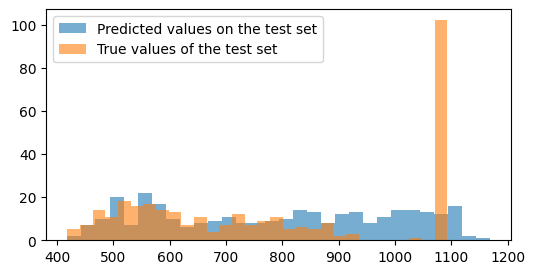

In [111]:
plt.figure(figsize=(6, 3))
plt.hist(y_val_pred, bins=30, alpha=0.6, label='Predicted values on the test set')
plt.hist(y_val, bins=30, alpha=0.6, label='True values of the test set')
plt.legend()
plt.show()

### Approach 2: Comprehensive aggregation (TSFresh) + gradient boosting + classification

### Stage 1: classification

Let's call values equal to 1093 outliers.


In [123]:
y = (y_data == 1093).astype(int)
X = pd.concat([X_data[file].assign(id=file) for file in y_data.index], axis=0, ignore_index=True)

settings = ComprehensiveFCParameters()
X = extract_features(X, 
                     column_id="id", 
                     default_fc_parameters=settings).loc[y.index]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.15, random_state=1)

Feature Extraction: 100%|██████████| 30/30 [03:41<00:00,  7.39s/it]


In [124]:
X_train_filtered = select_features(X_train.dropna(axis=1), pd.Series(y_train['predicted']), ml_task='classification',  fdr_level=1e-10)
relevant_features = set(X_train_filtered.columns)

X_train_filtered = X_train[list(relevant_features)]
X_val_filtered = X_val[list(relevant_features)]

X_train_filtered.head()

,CO__quantile__q_0.3,"H2__fft_coefficient__attr_""abs""__coeff_84","H2__agg_linear_trend__attr_""stderr""__chunk_len_5__f_agg_""mean""","H2__fft_coefficient__attr_""abs""__coeff_37","C2H2__cwt_coefficients__coeff_2__w_10__widths_(2, 5, 10, 20)","C2H2__cwt_coefficients__coeff_3__w_20__widths_(2, 5, 10, 20)","C2H4__fft_coefficient__attr_""real""__coeff_85","H2__fft_coefficient__attr_""real""__coeff_92","C2H2__fft_coefficient__attr_""real""__coeff_92","C2H2__fft_coefficient__attr_""abs""__coeff_32",...,"C2H4__fft_coefficient__attr_""real""__coeff_91","H2__fft_coefficient__attr_""imag""__coeff_25","C2H2__change_quantiles__f_agg_""mean""__isabs_True__qh_0.8__ql_0.0","C2H2__fft_coefficient__attr_""imag""__coeff_32","CO__fft_coefficient__attr_""imag""__coeff_10","CO__change_quantiles__f_agg_""mean""__isabs_True__qh_1.0__ql_0.6","C2H4__agg_linear_trend__attr_""slope""__chunk_len_10__f_agg_""mean""","CO__fft_coefficient__attr_""abs""__coeff_11","CO__fft_coefficient__attr_""real""__coeff_17",CO__c3__lag_3
id,,,,,,,,,,,,,,,,,,,,,
2_trans_2516.csv,0.023095,0.000488,1.599637e-07,0.001049,6.048963e-05,6.501273e-05,-0.000532,-0.000285,-2.407720e-06,0.000010,...,-0.000532,0.001521,1.703223e-07,0.000010,0.082538,0.000049,0.000025,0.075240,-0.005335,1.943549e-05
2_trans_2026.csv,0.022571,0.000800,2.967816e-07,0.001721,1.025092e-04,1.090707e-04,-0.001818,-0.000468,-6.352513e-05,0.000269,...,-0.001820,0.002491,1.751070e-07,0.000263,0.057220,0.000026,0.000079,0.052127,-0.003519,1.344197e-05
2_trans_2976.csv,0.001265,0.000886,2.791327e-07,0.001907,5.745808e-07,7.481171e-07,-0.000158,-0.000519,-1.322612e-06,0.000004,...,-0.000158,0.002760,1.337964e-07,0.000003,0.010060,0.000011,0.000004,0.009173,-0.000498,1.028895e-08
2_trans_2838.csv,0.001478,0.001134,6.836915e-07,0.002440,1.291415e-05,7.580825e-06,0.000067,-0.000663,-4.413991e-07,0.000002,...,0.000066,0.003536,1.169306e-07,0.000002,-0.006628,0.000005,-0.000010,0.006088,0.000661,1.209771e-08
2_trans_633.csv,0.021966,0.000387,2.369389e-07,0.000833,1.550568e-04,1.668536e-04,-0.001769,-0.000226,-8.232733e-05,0.000349,...,-0.001770,0.001208,3.281433e-07,0.000340,0.010904,0.000008,0.000090,0.009856,-0.000416,1.191125e-05


In [125]:
StSc = StandardScaler()
X_train_sc = StSc.fit_transform(X_train_filtered)
X_val_sc = StSc.transform(X_val_filtered)

### LogisticRegression

In [115]:
LogReg = LogisticRegression(solver='saga', verbose=0, n_jobs=-1, random_state=1, C=5)
LogReg.fit(pd.DataFrame(X_train_sc).dropna(axis=1).values, y_train)

y_train_pred_outliers = pd.DataFrame(LogReg.predict(X_train_sc), 
                                     index=y_train.index, 
                                     columns=y_train.columns)
y_val_pred_outliers = pd.DataFrame(LogReg.predict(X_val_sc), 
                                   index=y_val.index, 
                                   columns=y_val.columns)

f1_train = round(f1_score(y_train, y_train_pred_outliers), 2)
f1_val = round(f1_score(y_val, y_val_pred_outliers), 2)
print(f'F1 on train set = {f1_train}')
print(f'F1 on test set = {f1_val}')

/home/main/anaconda3/envs/scintific/lib/python3.10/site-packages/sklearn/utils/validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


F1 on train set = 0.84
F1 on test set = 0.78


/home/main/anaconda3/envs/scintific/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


### SVC

In [116]:
from sklearn.svm import SVC as SVC_class

In [126]:
SVC = SVC_class(verbose=0, random_state=1, C=5)
SVC.fit(pd.DataFrame(X_train_sc).dropna(axis=1).values, y_train)

y_train_pred_outliers = pd.DataFrame(SVC.predict(X_train_sc), 
                                     index=y_train.index, 
                                     columns=y_train.columns)
y_val_pred_outliers = pd.DataFrame(SVC.predict(X_val_sc), 
                                   index=y_val.index, 
                                   columns=y_val.columns)
f1_train = round(f1_score(y_train, y_train_pred_outliers), 2)
f1_val = round(f1_score(y_val, y_val_pred_outliers), 2)
print(f'F1 on train set = {f1_train}')
print(f'F1 on test set = {f1_val}')

/home/main/anaconda3/envs/scintific/lib/python3.10/site-packages/sklearn/utils/validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


F1 on train set = 0.92
F1 on test set = 0.77


### Stage 2: gradient boosting regression

In [132]:
y = y_data.copy()

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.15, random_state=1)

X_train_filtered = select_features(X_train.dropna(axis=1), pd.Series(y_train['predicted']), ml_task='regression',  fdr_level=1e-15)
relevant_features = set(X_train_filtered.columns)

X_train_filtered = X_train[list(relevant_features)]
X_val_filtered = X_val[list(relevant_features)]

StSc = StandardScaler()
# X_train_wo_outliers_sc = StSc.fit_transform(X_train_wo_outliers)
X_train_sc = StSc.fit_transform(X_train_filtered)
X_val_sc = StSc.transform(X_val_filtered)

In [133]:
X_train_sc.shape

(1785, 1803)

In [149]:
cbr = CatBoostRegressor(random_state=1,task_type='GPU', verbose=1, learning_rate=0.01, early_stopping_rounds=2, od_pval=0.01, depth=15, max_leaves=100, grow_policy='Lossguide', iterations=500)
cbr.fit(X_train_sc, y_train)

y_train_pred = pd.DataFrame(cbr.predict(X_train_sc), 
                            index=y_train.index, 
                            columns=y_train.columns)
y_val_pred = pd.DataFrame(cbr.predict(X_val_sc), 
                          index=y_val.index, 
                          columns=y_val.columns)

0:	learn: 241.7494316	total: 78.5ms	remaining: 39.2s
1:	learn: 239.7033928	total: 143ms	remaining: 35.6s
2:	learn: 237.6530154	total: 208ms	remaining: 34.4s
3:	learn: 235.6275464	total: 277ms	remaining: 34.4s
4:	learn: 233.6172358	total: 352ms	remaining: 34.8s
5:	learn: 231.6544321	total: 416ms	remaining: 34.2s
6:	learn: 229.6820552	total: 478ms	remaining: 33.7s
7:	learn: 227.7135947	total: 538ms	remaining: 33.1s
8:	learn: 225.7904931	total: 605ms	remaining: 33s
9:	learn: 223.8993972	total: 667ms	remaining: 32.7s
10:	learn: 221.9933933	total: 724ms	remaining: 32.2s
11:	learn: 220.1127697	total: 782ms	remaining: 31.8s
12:	learn: 218.2361274	total: 851ms	remaining: 31.9s
13:	learn: 216.4143034	total: 907ms	remaining: 31.5s
14:	learn: 214.5936685	total: 968ms	remaining: 31.3s
15:	learn: 212.7952317	total: 1.04s	remaining: 31.4s
16:	learn: 210.9895905	total: 1.1s	remaining: 31.1s
17:	learn: 209.2075699	total: 1.16s	remaining: 31.1s
18:	learn: 207.4524143	total: 1.22s	remaining: 30.9s
19:	l

In [150]:
ind = y_train_pred_outliers[y_train_pred_outliers['predicted']==1].index
y_train_pred.loc[ind] = 1093

ind = y_val_pred_outliers[y_val_pred_outliers['predicted']==1].index
y_val_pred.loc[ind] = 1093

mae_train = round(mean_absolute_error(y_train, y_train_pred), 2)
mae_val = round(mean_absolute_error(y_val, y_val_pred), 2)
print(f'MAE on train set = {mae_train}')
print(f'MAE on test set = {mae_val}')

MAE on train set = 12.56
MAE on test set = 61.36


Better than linear regression but worse than previous gradboosting regression. Previous metrics:
- MAE on train set = 37.2
- MAE on test set = 91.37

We still need to deal with overfitting but for the last algorithm overfitting is much less. So, in total the last algorithm is much better.

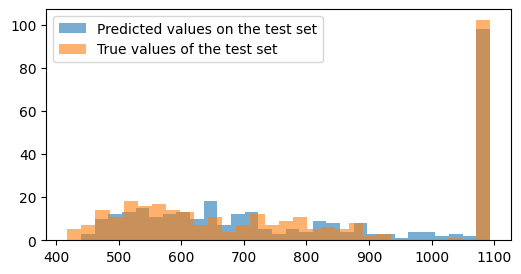

In [151]:
plt.figure(figsize=(6, 3))
plt.hist(y_val_pred, bins=30, alpha=0.6, label='Predicted values on the test set')
plt.hist(y_val, bins=30, alpha=0.6, label='True values of the test set')
plt.legend()
plt.show()